In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import QuantumCircuit, Aer, execute, IBMQ
import import_ipynb
import circuitgenerator as circ


ModuleNotFoundError: No module named 'qiskit'

In [2]:
def determine_color(state):
    if state == '0':
        color='red'
    elif state=='1':
        color='green'
    elif state=='2':
        color='forestgreen'
    elif state=='3':
        color='darkgreen'
    return color

def make_counts_hist(counts_results):
    probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    print(probabilities)
    plt.bar(list(counts_results.keys()), counts_results.values())
    plt.ylabel('Counts')    
    plt.xticks(list(counts_results.keys()), [None])
    xpos_text = -0.3
    for key in counts_results:
        Cstate=key[0]
        Bstate=key[1]
        Astate=key[2]
        Ccolor, Bcolor, Acolor = determine_color(Cstate, Bstate, Astate)
        plt.text(xpos_text, -200,'Cases', color=Ccolor)
        plt.text(xpos_text, -400, 'Tests', color=Bcolor)
        plt.text(xpos_text, -600,'Home', color=Acolor)
        xpos_text += 1
    plt.show()
    return

def get_marginal_probabilities(state_counts, whichstate=0):
    #state_counts: dict, counts for each state from network result (should have 2^n entries)
    #whichstate: integer representing the state that you want the marginal probability of (for a 2-state system this
        #could be 0 or 1).
    #marg_probs: array of length n, marginal probabilities that each qubit is whichstate,
        #from most significant to least significant qubit
    
    n = len(list(state_counts.keys())[0]) #number of qubits
    prob = np.zeros(n)
    total = sum(state_counts.values())

    for i in range(n):
        for key in state_counts:
            if int(key[i]) == whichstate:
                prob[i] += state_counts[key]
        prob[i] = prob[i]/total
    
    return prob

def make_prob_hist(counts_results, var_labels, top_n_probs='all', whichvar=['all',2], probdict={}):
    """
    INPUTS: counts_results: dictionary from circuitgenerator where keys are multi-qubit states and values are counts
            var_labels: IF WHICHVAR[0] = 'all': list of strings of variable names. Order of variable names in var_labels needs to be the same
                as the order of variables in a multi-qubit state in counts_results
                IF WHICHVAR[0] is not 'all': list of strings of state names for the variable chosen in whichvar
            top_n_probs: optional. So that you can make a histogram of n most likely probabilities. Default='all'. 
                Change to integer if you only want top n
            whichvar: list- first entry integer giving index of the variable in a key of counts_results that you want to marginal 
                probabilities for. Default='all' includes all variables and doesn't calculate marginal probabilities.
                Second entry is the number of states that variable can be in. Default is 2 states.
            probdict: dictionary of probabilities you want a histogram of. keys will be label on x axis and values will
                be probabilities.
    """
    if probdict == {}:
        counts_results = dict(sorted(counts_results.items(), key=operator.itemgetter(1),reverse=True)) #sorts dictionary by decreasing counts
        probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    else: #this example is to plot most probable ways to get decreasing deaths or cases
        probabilities = probdict
        plt.bar(probabilities.keys(), probabilities.values())
        plt.ylabel('Probability')
        plt.xticks(rotation=90)
        plt.title('Most Probable ')
        plt.show()
        return
    
    if (top_n_probs == 'all') & (whichvar[0] == 'all'):
        plt.bar(np.arange(len(counts_results)), probabilities)
        plt.ylabel('Probability')
        plt.xticks(np.arange(len(counts_results)), [None])
        xpos_text = -0.3
        for key in counts_results:
            for i in range(len(key)):
                state=key[i]
                color = determine_color(state)
                plt.text(xpos_text, -0.03-0.02*i,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
    elif (top_n_probs != 'all') & (whichvar[0] == 'all'):
        plt.bar(np.arange(top_n_probs), probabilities[0:top_n_probs])
        plt.ylabel('Probability')
        plt.xticks(np.arange(top_n_probs), [None])
        xpos_text = -0.3
        counter = 0
        for key in counts_results:
            if counter < top_n_probs:
                for i in range(len(key)):
                    state=key[i]
                    color = determine_color(state)
                    plt.text(xpos_text, -0.03-0.02*i,var_labels[i], color=color)
                xpos_text += 1
                counter += 1
        plt.show()
        
    elif (top_n_probs == 'all') & (whichvar[0] != 'all'):
        pvar = []
        for i in range(whichvar[1]):
            pvar.append(get_marginal_probabilities(counts_results, whichstate=i)[whichvar[0]])
        plt.bar(np.arange(whichvar[1]), pvar)
        plt.ylabel('Probability')
        plt.xticks(np.arange(whichvar[1]), [None])
        xpos_text = -0.3
        for i in range(len(pvar)):
            state = i
            color = determine_color(str(state))
            plt.text(xpos_text, -0.07,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
        
    elif (top_n_probs != 'all') & (whichvar[0] != 'all'):
        pvar = []
        for i in range(whichvar[1]):
            pvar.append(get_marginal_probabilities(counts_results, whichstate=i)[whichvar[0]])
        numbars = min(whichvar[1], top_n_probs)
        plt.bar(np.arange(numbars), pvar)
        plt.ylabel('Probability')
        plt.xticks(np.arange(numbars), [None])
        xpos_text = -0.3
        for i in range(numbars):
            state = i
            color = determine_color(str(state))
            plt.text(xpos_text, -0.07,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
    return
        


In [7]:
results = {'000': 2783, '001': 1240, '100': 603, '111': 815, '110': 294, '010': 1712, '101': 485, '011': 260}

results_maxtomin = {'000': 2783, '010': 1712, '001': 1240, '111': 815, '100': 603, '101': 485, '110': 294, '011': 260}

graph = {'StayAtHome': ([], [0.645, 0.355]), 'Testing': ([], [0.62, 0.38]), 'Cases': (['StayAtHome', 'Testing'], [0.8181818181818182, 0.18181818181818182, 0.8412698412698413, 0.15873015873015872, 0.7068965517241379, 0.29310344827586204, 0.23076923076923078, 0.7692307692307693])}

alabio_counts_results = {'0001010100100101': 8, '0001101100011011': 2, '0101010011010100': 2, '0000111101100001': 1, '0001011000101011': 1, '0001111011100111': 1, '0000111001001000': 1, '0000110101000100': 1, '0001101101011000': 6, '0001110101010000': 1, '0000010001001001': 1, '0000001001011010': 1, '0000110101010100': 4, '0001110010011001': 2, '0001100110011010': 2, '0000101111101000': 16, '0011000011111001': 1, '1001010010101000': 9, '0000110110101011': 2, '0000000101001000': 2, '0000110101001000': 1, '1000000110010101': 1, '0001111011101010': 1, '1001111100011010': 2, '0000110000101010': 2, '0001001011010100': 3, '0000011010011000': 3, '0001000001110100': 1, '0001001101101010': 12, '0010101101010100': 1, '1000100000111000': 1, '0000101000101001': 6, '0001000101010100': 1, '0000110100011010': 6, '0000001111011010': 1, '0000010010011011': 1, '0001000100010001': 1, '0100010110100101': 3, '0000000101101001': 11, '1111010101010111': 3, '0000000000101000': 7, '0001011010111010': 1, '0001100000101010': 2, '1001111001011001': 1, '0001001011101011': 5, '0000011100100001': 1, '0000011101011001': 4, '1101011100100100': 1, '0001110100011011': 1, '0001000011001010': 1, '0001010100001000': 2, '0010011011100100': 3, '0000010110011010': 1, '0000110011001010': 1, '0000011011010101': 1, '0000010001100110': 1, '1010100010111001': 1, '1000000011011011': 1, '0000010010011000': 4, '0001111101111010': 1, '0000101111011010': 2, '0000110011011010': 2, '0001001010101011': 4, '1100000101100101': 2, '0000100111011001': 5, '0111010010111001': 1, '0001000111101001': 14, '1000100010011010': 1, '0101110111100101': 2, '0000110011010101': 2, '0001110100111010': 2, '0000001100011001': 1, '0001011010010010': 1, '0001001100101011': 5, '0000111110101000': 11, '0001100101100100': 3, '0000110100011011': 1, '0000011000101001': 2, '0000010101011001': 6, '0001100110010101': 2, '0000010101001000': 1, '0001110110101010': 4, '0000110000100110': 1, '0000011001101010': 3, '0000000100101011': 3, '0001111011011011': 2, '1001111001101000': 5, '1111111100101010': 3, '0001001100001011': 1, '1001010101100101': 1, '0110001000100100': 2, '1000101011011010': 2, '0000010011101010': 3, '0000010100100110': 1, '0001110010011010': 1, '0000111100101000': 9, '0110110010111001': 2, '0001000110111001': 1, '0001110100101011': 1, '0001000101010001': 1, '1000101011101010': 3, '0000010011010100': 1, '0000100101001001': 2, '0000100101100000': 2, '1001010010101011': 2, '0000100110011001': 5, '0000111100001010': 1, '0000111101000101': 1, '0111011101101011': 6, '1110101010100100': 1, '0100001100010110': 1, '0011001010100101': 3, '0000000010101000': 12, '0000001011011001': 7, '0000000000011010': 1, '0001110110101000': 7, '0000101010101010': 6, '0000111111101011': 2, '0010010100100100': 1, '0101011011101001': 14, '0011111011101000': 2, '0001111110011000': 5, '0001011010010000': 1, '0000101101011000': 17, '0001011001101010': 2, '0000100001101010': 4, '0001000100100110': 1, '0000011100101000': 6, '0001010001100101': 1, '0000101111011001': 6, '0001010010111010': 1, '0001011010010101': 3, '0001100000101000': 3, '1001010110101011': 1, '0000111110101011': 1, '0100110010010100': 1, '0000010110100100': 1, '0001111111101010': 2, '0001110011011000': 7, '0001011110101011': 2, '0000110110001001': 1, '0001010000100101': 1, '0001100110100100': 3, '0001010110001001': 1, '0000001101001001': 1, '0001111000101000': 1, '0001100001011001': 2, '0001001001101001': 11, '0000101000101010': 3, '0001110000011000': 1, '0000001011011010': 1, '0001010110111000': 3, '1001010110101001': 2, '0000011010011010': 1, '0111011100101011': 7, '0000110100100100': 1, '0000011101111001': 1, '0001011111101000': 13, '0000010010101010': 3, '0001110111101011': 1, '0000001011010111': 1, '0000100010100100': 2, '0000111111010010': 1, '0000000100111000': 1, '0001010011011010': 5, '0000001111011001': 2, '0000101101010011': 1, '0000110011101001': 11, '0000110111011010': 1, '0010111110010101': 2, '0111010010100100': 3, '0000011010011011': 2, '0000111011011000': 5, '0010111010101000': 20, '0001001000110101': 1, '1110101001100100': 2, '0110111100010110': 1, '1100101011101001': 11, '0001000001101001': 6, '0000010111100110': 1, '0000001111010111': 1, '0000110101011000': 19, '0001000111010000': 1, '0000000111111001': 1, '0001000011011000': 25, '0000100001010100': 1, '0001001100011011': 1, '0001011011100110': 2, '0000110101100101': 4, '0001100100101010': 3, '0001100101101000': 16, '0000110001101000': 14, '0000110110101001': 11, '0001001110101000': 10, '0001000011101011': 4, '0000110100011001': 11, '0000110101101001': 20, '0000111100111001': 1, '0000110000101000': 11, '0001100010011001': 2, '0001100010011010': 1, '1001010101101001': 14, '0110000000100101': 1, '0001010111101011': 3, '0000110101001001': 2, '1100101010101001': 7, '0010110100100100': 2, '0000110111010100': 1, '0001000101111001': 1, '0100110111100101': 3, '0001010100011000': 29, '0000011000010000': 1, '0000111011010111': 1, '0001110100011000': 7, '1101011100100101': 2, '0000010110001001': 1, '0000000011011001': 1, '0000011111011010': 3, '0001101010011001': 3, '0111011100010110': 2, '0000110010011000': 13, '0001001110101011': 4, '0001111100011001': 2, '0001000101000110': 1, '0000001101100100': 2, '0000000010100001': 1, '1000001100011000': 4, '0000110011011011': 3, '0000010111010111': 1, '0001000110110100': 1, '1000100000101001': 1, '0110001011010100': 1, '0001000111100011': 1, '0001010111001000': 3, '0001110101111000': 2, '0101001110010101': 2, '0000000001011010': 1, '0000000101101010': 2, '0001000111101010': 8, '0001100101011001': 10, '0000110111001001': 1, '0001000010010001': 1, '0000110000111000': 2, '0001111110001000': 1, '0001000111100100': 2, '0001101011010101': 1, '0001000001101011': 7, '0001010101111010': 2, '0000001110011001': 2, '0001011010100110': 2, '0000101100011000': 11, '0001011110011000': 11, '0111000000010111': 1, '0010110101100100': 2, '0001011001010110': 1, '0001001000111000': 1, '0001011101010001': 1, '0001100011011001': 4, '0010101111010101': 1, '0010111011100100': 1, '0001101100100000': 2, '0001011101110001': 1, '0001101110101000': 8, '0001110100101001': 9, '0001010011010000': 1, '0001100011100000': 1, '0000111011111011': 1, '0001010101100110': 2, '0001100110101001': 6, '0001001100101010': 11, '0001011110111000': 2, '0001100110011001': 4, '0101011101101000': 18, '1001010110011001': 2, '0001010011011011': 1, '0000000101010100': 1, '0001001000011000': 9, '0101100100100101': 2, '0000111111011010': 2, '0001101101100110': 1, '1100100101100111': 1, '1000000110101011': 1, '0100000011010100': 1, '0000011000100111': 2, '0001111010111000': 3, '0001001101010001': 1, '0000100110010101': 1, '0000110101100001': 1, '0001110011010101': 1, '0000100101001000': 1, '1100100101100101': 3, '0001111010010101': 1, '0001011100101001': 23, '0001010110001010': 1, '0001011010101011': 6, '1001010101110100': 2, '0000111101011011': 2, '0001010001011001': 5, '0000010000101000': 3, '0000100111010101': 2, '0001111101011000': 6, '0001010111100100': 4, '0001011010011001': 9, '0101010101010100': 1, '0000001000011001': 3, '1001111100011001': 2, '0001101010011010': 2, '0001111011010000': 1, '0000110110010011': 1, '0000100001101000': 12, '0001010011101011': 4, '0001110101011001': 4, '1000000011101000': 9, '0001010110101000': 22, '0001000011100110': 3, '0100010111010101': 1, '0000010100100101': 2, '0000110101011011': 5, '0001101001101010': 1, '0001000111111001': 1, '0110110010100100': 4, '0000110100101001': 24, '0001001001100101': 2, '0011111100100100': 3, '0000110001011000': 7, '1000001100011001': 3, '0001110111100100': 1, '0000110011010110': 1, '0000000000011011': 2, '0001100000111011': 1, '0001011000011001': 6, '0000011100011011': 2, '0010111100100100': 2, '0001101100001000': 3, '1001010011001000': 1, '0000111001011011': 1, '0001011101100110': 2, '0000110111101011': 1, '0000101100111000': 1, '0001000101111000': 2, '0000101001101010': 2, '0000000101110101': 1, '0101011011100101': 2, '0011101010101000': 9, '1011111011101000': 5, '1001010110101000': 9, '1001010101100100': 5, '1111111100010110': 1, '0001011110010101': 2, '0000010010011001': 3, '0001001101101011': 6, '0001101011011010': 2, '0000001101111010': 1, '0000110001010100': 1, '0000010110011001': 1, '0000000100011000': 11, '0000010000001001': 1, '0001001001101010': 3, '0001000100010101': 4, '0001001011011001': 13, '0100111010101001': 15, '0000100101101011': 3, '1000000010100100': 1, '0001100010100110': 1, '0000010101100101': 2, '1000101001111000': 2, '1001010110011011': 1, '0001000011111000': 4, '0000011001101011': 1, '0000110100011000': 14, '0100001011101001': 4, '1001010101011000': 12, '0101110011100101': 2, '0001100011100100': 4, '0000011110111000': 1, '1011001101010100': 2, '1000101011000100': 1, '0000010100100010': 1, '0001001000101001': 6, '0000111110011001': 5, '0001100100010100': 2, '0000100101101010': 8, '0000111010100110': 1, '0000011001101000': 2, '0110110011111001': 1, '0001110001011001': 2, '0000110011110100': 1, '0101000101100101': 10, '1000001100101011': 2, '0000100010011010': 1, '0100011101101000': 5, '0000000010010100': 1, '0001110100101010': 3, '0000010111010100': 1, '1001010101100110': 2, '0001010111101010': 7, '0001111111011011': 1, '0001100010100001': 1, '0011101010100100': 1, '0001001011001000': 1, '0000010101101000': 22, '0001010100010101': 4, '0000111100010100': 2, '0000011100011010': 4, '0000010010100111': 1, '0001001010100110': 1, '0000111111000110': 1, '0001010000100100': 1, '0000100011101010': 2, '0000100011011011': 1, '0001000000001001': 1, '0001010101101001': 18, '0001110101001010': 1, '0000111101100111': 1, '0000010000100101': 1, '0001001100011010': 4, '0001011001101000': 9, '1110101001101011': 1, '0001001110111001': 1, '0000011010111000': 1, '0001000111100101': 3, '0000010101111000': 1, '0001111011011010': 1, '1001010101001001': 1, '0001101010011000': 5, '0001101111011010': 2, '0000000101011001': 7, '0001010001101000': 16, '0001110100100100': 3, '0000010101101010': 3, '1001010011011000': 5, '0001010111011011': 2, '0001000100101010': 10, '0001000100001011': 1, '0000011011101010': 4, '0000110010101000': 26, '0001111100101000': 5, '0001101010001001': 1, '0000100110100100': 3, '0000111000101000': 4, '0011001100010100': 2, '1110101011010110': 1, '0000010100011011': 2, '0110100000100101': 1, '0000011100010100': 1, '1000000011011000': 7, '0000101001101001': 4, '0000110010011010': 3, '1100101101010110': 1, '0001001100011000': 21, '0000011101001001': 1, '0000010101011010': 3, '1000101011010101': 1, '1100100111010111': 1, '0001101101011001': 2, '0000010100010101': 3, '0000111101011010': 5, '0100010110010101': 1, '0001011101011001': 20, '0001101100101000': 12, '0000011110011011': 2, '0000001110101010': 1, '0000100110001000': 2, '0000111000010000': 1, '0000111100011001': 8, '0011000010111001': 1, '0001011111010000': 1, '0111000101010110': 1, '0001001101101001': 26, '0001100111111011': 1, '0001110100100101': 1, '0001010110101010': 2, '0000111001011001': 4, '0000111010011001': 4, '0000111001011000': 5, '0110101011010100': 1, '0001011110101010': 4, '0100000010101001': 6, '0001010100011010': 3, '0001010011100111': 2, '0001001101100010': 1, '0001110101100100': 2, '0000011111011011': 1, '0001000110010100': 2, '0001010001001010': 2, '0001011110010001': 1, '0001000010011000': 20, '0001000100100100': 8, '0000110001100000': 1, '0000101000010111': 1, '0001000010111011': 1, '1111010111100100': 1, '0011101100010100': 2, '0000001011001000': 1, '0011000010010000': 2, '0000111000010100': 1, '0000101010110100': 1, '0001001001011011': 1, '0000010001010101': 1, '0000101111011000': 10, '0110110011010100': 1, '0001000101011001': 15, '0000110000001000': 1, '1000001100101001': 5, '0001100101001001': 2, '0001100011011000': 4, '0001000110011011': 1, '0000110111101000': 15, '0001000101101011': 4, '0001010011101010': 5, '0001000100100000': 1, '0000000100101001': 11, '0000111101001001': 1, '0000010010010001': 2, '0001000001101010': 8, '0000100110001001': 1, '0000001000011000': 3, '0001111111101000': 7, '0000110011010111': 1, '0001001000010100': 3, '0000111010010000': 1, '0000011111111001': 1, '0001001110100100': 4, '0000110100111001': 2, '0001110010011011': 3, '0001000011000100': 1, '0001101000101001': 2, '1000000010101011': 2, '0001101001011001': 1, '0001100001101001': 2, '0000110100111000': 3, '0001000010111000': 2, '1001010010011000': 3, '0101011110010100': 2, '0110000011100111': 1, '0001000011100000': 1, '0001000100001000': 4, '0011001011100100': 1, '0001101000011010': 1, '0000100011010101': 2, '0000100101010101': 3, '0111101010010100': 1, '0101001000100110': 2, '0001101110111010': 1, '0000001101010100': 1, '0001010111100110': 3, '0000000100001001': 1, '0001000100011000': 27, '0001010001101010': 7, '0001011100011001': 10, '1001010011101001': 5, '0110111100101011': 2, '0001010000011001': 6, '0011001011101000': 26, '0110000001100100': 1, '0000100110011011': 1, '0001100001101011': 1, '0001001110011011': 1, '0000111010011011': 4, '0000000001101011': 2, '0000110111100000': 1, '0001010011011000': 16, '0001000011011001': 21, '1011011101100100': 4, '0001011100001000': 3, '0000011110011010': 2, '0000010111101000': 8, '0001101000011000': 1, '1000000010100110': 1, '0000010111100100': 1, '0001010100111001': 2, '1000101011100000': 1, '0000000001011001': 4, '0001100010100100': 2, '0001010101100000': 1, '0000011001101001': 4, '0000111110000110': 1, '1000001100010111': 1, '0000100100111010': 1, '0000001101101011': 1, '0001111111011001': 3, '0001001011010000': 1, '0001010001010100': 1, '0001100110111001': 1, '0000110010010101': 3, '0000101100001010': 1, '0000001010011001': 4, '0001011011101011': 2, '0000010110010100': 1, '0000110100010000': 1, '0000101001011000': 1, '0000110110111011': 1, '0101001010101001': 24, '0001101101100101': 2, '0000010101011000': 6, '0001000000011001': 7, '0000110100001001': 2, '0000010100101010': 8, '1001010010101010': 4, '0000111110101010': 3, '0000111110110101': 1, '0111110101010110': 1, '1000101011010100': 1, '0001011101011010': 8, '0000101000001000': 2, '0000111111110100': 1, '0011001010101000': 21, '0001010001011011': 1, '0000010110100000': 1, '0000001100011011': 3, '0000000100101010': 5, '0000100101110111': 1, '1000000110011001': 2, '0001001000111001': 1, '0000101100001011': 1, '0101111101101000': 8, '0000110011110110': 1, '0101111011100101': 1, '0000011101010010': 1, '0101010111010101': 1, '0101100100010100': 1, '0001000110011001': 8, '0001000111111011': 1, '0001100001011000': 3, '0001110101011000': 11, '0000101101110111': 1, '0001010010010001': 1, '0001010111111000': 4, '0000101100101001': 16, '0001011100001001': 1, '0000111000001001': 1, '0001000110101010': 5, '1000000011011001': 1, '0000100010011000': 12, '0110000000100100': 2, '0001000110101000': 29, '0001100101011011': 1, '0001100010100000': 3, '0000010100111000': 1, '0000110011011001': 5, '0001110101101011': 3, '0111100000100100': 3, '0010111011101000': 20, '0000111001101000': 10, '0001001100001001': 2, '0001010111111001': 1, '0000001001101001': 2, '0110101011111000': 1, '0011110010100100': 2, '0000001101101001': 9, '0001000010010100': 2, '0000010010010100': 2, '0000110001011011': 1, '0001011111011010': 1, '0000000101101000': 16, '0001010010100110': 2, '0001000000101010': 2, '0001010000001010': 2, '0000010010101000': 17, '1001010101101000': 33, '0001011101010011': 1, '0000101000011010': 1, '0000011110011001': 1, '0000101100001001': 1, '0000001100011000': 7, '0000011000101010': 1, '0000000111001000': 1, '0111011101010110': 1, '0000101010011001': 5, '0100000100100101': 1, '0000101011011001': 2, '1000100010101000': 6, '0001011110001001': 3, '0000001011101010': 3, '0000100011111000': 2, '0001110001101010': 3, '0000000000101001': 3, '0000111010101010': 3, '0000110010110100': 1, '0000110100101010': 7, '0000111010010110': 1, '0001001010100010': 1, '0100011100100101': 1, '0000101110101011': 1, '0001001111001010': 2, '0001001111011001': 4, '0001000011101000': 34, '1001010110111000': 2, '0000101010010101': 1, '0001011001011000': 7, '0001000101100100': 5, '0000110001101001': 7, '0101101011010100': 1, '0000111111100100': 1, '0101000100010100': 2, '0001101100100100': 1, '0000100011101000': 25, '0001010001011010': 2, '0000000000010101': 1, '0000110010001010': 1, '0000101110100100': 4, '0000011111001001': 1, '0000110101101010': 9, '0001000111100001': 1, '0000111011011011': 3, '0111000101100111': 1, '0001101110101001': 3, '0101010011100101': 9, '1111111101101010': 1, '0001011100010000': 1, '0001110101011010': 1, '1001010010101001': 4, '0001010100101011': 11, '0001000101001000': 4, '0000001010111010': 1, '0001011101010100': 4, '0000100010000101': 1, '0001010001111001': 2, '0000110011111010': 1, '0001111100011010': 1, '1000101011011011': 1, '0001010110111001': 1, '0001010100001010': 2, '0000111001101001': 5, '0001011100101000': 28, '0001000111011001': 8, '0111011100010101': 1, '0110111100111000': 2, '0000000010011000': 4, '0000111110100100': 1, '0011101011101000': 7, '0010100100010100': 2, '0001110101100101': 4, '0001110001010100': 1, '0001000011010100': 2, '0000011101011011': 1, '0001010010111000': 3, '0000000101011000': 11, '0001011111011000': 7, '0000011111101010': 2, '0000100110011000': 5, '0000100100110110': 1, '0001000011010111': 2, '0001001111100101': 1, '0111001000100100': 3, '0000011111011001': 1, '0000011011011010': 1, '0001000111101000': 22, '1000100010101011': 2, '0000000111011001': 2, '0001001011011011': 2, '0001010110001000': 2, '0001011100100000': 1, '0000011001011000': 2, '0001101100010010': 1, '0001101101101010': 1, '0000101010111001': 1, '0001010001011000': 10, '0001000101001011': 2, '0000001011101011': 2, '0011111010101000': 9, '0001011001011001': 2, '0000111111011001': 6, '0001110110101001': 8, '0000111111010110': 1, '0000101101010000': 1, '0000010010110011': 1, '0000000100011001': 3, '0000000010010111': 1, '0000011011110101': 1, '0000011001011011': 1, '0100101000101000': 13, '0100000011101001': 1, '0110101000100100': 1, '0000100011100100': 4, '0100111100100101': 2, '0000011100011000': 10, '0001010101010101': 3, '0000001010001001': 1, '0000110101111001': 2, '0000110000011010': 1, '0100111011100101': 2, '0000110001010001': 1, '0001010010101000': 33, '0001110000101001': 3, '0000100011100000': 1, '0001000011101010': 11, '0000111010100001': 2, '0000101101101001': 15, '0000001001101010': 1, '0000100001011000': 7, '0001011011001001': 1, '0000100001011011': 1, '0000011101100000': 1, '1100100100100101': 2, '0001001001010101': 1, '0000110100100101': 5, '0000100001101001': 6, '1001111100101001': 1, '0001000111011011': 3, '1000100010110110': 1, '0000110011111000': 1, '0001001101101000': 37, '0000111101010100': 4, '1111010011111001': 3, '0011110011100100': 3, '1110101001010101': 1, '0001100010000001': 1, '0001001111011010': 6, '0000100111001000': 2, '0000101111100010': 1, '1000001100101000': 4, '1001010101111000': 1, '0000100100101001': 15, '0001010101011010': 3, '0000101100100000': 2, '1100101010100100': 1, '1111010111010100': 1, '1001010101011011': 3, '0000001100101001': 7, '0000111101001000': 2, '0000010010101011': 2, '0111000000010101': 1, '1110101011010100': 1, '0001001100010111': 1, '0000111000011000': 5, '1000100000101000': 8, '1001010010011001': 2, '0100011100101000': 7, '0001001100110100': 3, '0000100111110100': 1, '0000110111011000': 9, '0000000010000100': 1, '0001011011110101': 1, '0000010001100100': 1, '0000011011001000': 1, '0000010011101011': 1, '0001011001001000': 1, '0100011101100101': 2, '0000000100001000': 3, '0000010010011010': 3, '0001001011101010': 9, '0101111101100101': 1, '0001110000011011': 1, '0001001000010101': 1, '0001001111100100': 4, '0001000001011010': 4, '0111011010100101': 1, '0001100001011010': 2, '0010001101010100': 1, '0000001110011000': 2, '0001101011101011': 1, '0001111101011001': 5, '0001010010011000': 16, '1011011011101000': 27, '0001010000101010': 4, '0000110000111001': 1, '0000101100011010': 2, '0001011011010101': 2, '0011010100100100': 6, '0001011101111001': 2, '0001000111010100': 2, '0010101010100111': 1, '0001010100111011': 1, '0000011000101000': 2, '0001011110001000': 3, '0001110100111000': 2, '0010001011101000': 5, '0000110010011001': 7, '0100100011010100': 1, '0000010100011010': 1, '0000110110101000': 10, '0110111101101010': 8, '0000101100101011': 6, '0001100110100011': 1, '0001000010001001': 1, '0001101101110001': 1, '0000010101011011': 2, '0100000010010100': 1, '0101101011101001': 4, '0101001000101000': 10, '0001011010001000': 2, '0001110001101011': 2, '0001101101101011': 3, '0000101100001000': 1, '0000000101111001': 1, '0001101110101010': 1, '0001000001011001': 5, '1000000010101010': 1, '0000100111000110': 1, '0000001111011000': 2, '0001000010011001': 7, '0001010111101001': 14, '0100011101100100': 2, '0101000011101001': 10, '0000100100100110': 1, '0000110011101011': 2, '0000110100110100': 1, '0101111111010100': 2, '1100100101010100': 3, '0000101110101010': 2, '0101000011100101': 1, '0001100011010100': 2, '0001110011110100': 1, '0000101101101010': 2, '0101100101100101': 1, '0001000111101011': 1, '0000000101010000': 1, '0001010110101011': 2, '0101110101010100': 1, '0000000001101010': 1, '0000101100010000': 1, '0000011111101001': 2, '0000001101011000': 13, '0011011100100100': 1, '0001111011101011': 5, '0000001011010101': 1, '0001001101100000': 3, '0000100000101010': 3, '0001010101101000': 30, '0000000001011000': 2, '0000010011101001': 14, '0001001110101001': 10, '1001010101010001': 1, '0000100000100111': 1, '0001001000011001': 4, '0001001011111001': 1, '0001000000011010': 1, '0000101100101000': 25, '0001001111111011': 1, '0000010001011000': 2, '0001011101101001': 19, '0001111111011000': 2, '0100111010100101': 1, '0000100011011001': 8, '0000110010010110': 1, '0001111010111001': 3, '0001101100011000': 13, '0001011101011000': 17, '0000011110101001': 10, '1000100000011001': 1, '0001001110100101': 1, '0000110011101010': 5, '0101111100100100': 1, '0001011100011011': 3, '0000110010100110': 1, '1001010011010101': 1, '0001000010000100': 2, '0110001011111000': 1, '0001011100010100': 2, '0001101100100011': 1, '0001100001010010': 1, '0000011011111000': 1, '1111010011100100': 3, '0001110010101000': 13, '0000101111111000': 1, '0000101100010100': 2, '0000001111100100': 2, '0000100010101011': 5, '0001011111011011': 2, '0001010110011001': 9, '0000100110101000': 12, '0000011010101011': 2, '0000110000011000': 5, '0001011011011011': 1, '0001001111101000': 12, '0000011001100100': 2, '0001000010101000': 39, '0000111101101000': 5, '1011010011100100': 3, '0110001010010100': 1, '0001100000101001': 4, '0000110010101011': 3, '0110111100010101': 5, '0001001010001011': 1, '1000100010101001': 3, '0110110100010111': 1, '0001010010011001': 17, '1010000011100101': 2, '0000100011001000': 3, '0000000011011011': 1, '0001100100010101': 1, '0001001000101010': 3, '0111101101010110': 1, '0000100101001010': 2, '0110010101010110': 1, '0000111000111000': 1, '0111011100111000': 6, '0001011110010111': 1, '0000100011010111': 1, '1110000101010110': 1, '0000111101010000': 2, '0000100001101011': 2, '0001010100101000': 57, '0001100110101000': 3, '0001000010100000': 2, '0001001000011010': 2, '0000100110100101': 4, '0001010111111010': 1, '0001000101011000': 28, '1011011010101000': 30, '0001001101010101': 1, '0000110110011000': 6, '0000110001101011': 1, '0110010100010110': 1, '0001000111010101': 1, '0100100110010100': 2, '0001011000101000': 10, '0001001100111000': 3, '0001101111101000': 7, '0000100100101000': 25, '1001010011011011': 1, '0001001010001001': 1, '0001110111101000': 7, '0000110010101001': 14, '0001010000101001': 19, '0000010011011000': 5, '0000001100100100': 2, '0001110010010100': 1, '1001010101001000': 2, '0000110000010100': 1, '0001100101101001': 12, '0010011101100100': 1, '0001010100001001': 1, '0001011000011010': 3, '0000111110001000': 1, '0001010101000100': 1, '0000001001100101': 1, '0000011111101011': 1, '0000100011011000': 13, '0000010000010000': 1, '0000101110100101': 2, '0000100100100000': 1, '0001001011100001': 1, '0000110010111000': 2, '0000101101011010': 3, '0001110010100110': 2, '0101001011010100': 1, '0000110111001000': 1, '0001001100101001': 26, '0000000100010100': 1, '0001001111100001': 2, '0001010010011011': 4, '0001110101101000': 15, '0100011110010100': 2, '0001111010011010': 1, '0001010100100000': 3, '0000000100100100': 3, '0001011111101010': 3, '0001010011110101': 1, '1000000110101000': 12, '1000101011000101': 1, '0001100101010101': 1, '0010001101111001': 1, '0001111101011010': 1, '0000100111100011': 1, '0001110110101011': 1, '0001011100011010': 4, '0000001101101010': 1, '1101010100010100': 3, '0000000111100100': 2, '0000010100111010': 1, '0100101001101000': 13, '0000101010010100': 3, '0101011010101001': 14, '0001001001011001': 4, '0001100000011011': 2, '0010101010101000': 23, '0001000010101001': 16, '0001011010001001': 2, '0001110010010101': 2, '0001001010011010': 1, '0001110100100111': 1, '0001101100111011': 1, '0001010001111000': 1, '0001010101010100': 1, '0000000100011010': 6, '0001000110100100': 1, '0000000111011011': 1, '0000110100100110': 2, '0001010011100110': 2, '0001110110011011': 1, '0100110110100100': 1, '1000000110100000': 1, '1000000110011011': 1, '0001110001101000': 5, '0000010110101010': 1, '0001010111010111': 1, '0001011111010110': 1, '0111000001100100': 1, '1000000011010101': 1, '0001000011011010': 8, '0000010110010111': 1, '0001110101101001': 17, '1001111001101001': 4, '1001010011101000': 8, '0001011101001000': 1, '0001110110011000': 4, '0110110011100100': 1, '1000101000010100': 1, '1000101011101011': 4, '0000001100101000': 9, '0001101011011000': 5, '0001100100011000': 6, '0000101100110100': 1, '0001010010010000': 2, '0001010010001001': 1, '0001101011011001': 2, '0001111111100100': 1, '0001111100101001': 4, '0011010110100100': 1, '0111011100101010': 12, '0000001111011011': 1, '0001010111000110': 1, '0001011100000000': 1, '0111001010010100': 1, '0110100001100100': 2, '0000100000001001': 1, '0000100100010011': 1, '1000000110101001': 5, '0110010110100100': 1, '0100111011101001': 14, '0001101110100100': 2, '0001001010100001': 1, '0101000010101001': 12, '1000101011011001': 6, '0101000100100101': 1, '0000101110010110': 1, '0001011101011011': 4, '0001010000010100': 1, '0001001101100100': 2, '0001110111011010': 2, '0001010111011010': 5, '0000101011011000': 1, '0001100011110111': 1, '0001000101101010': 13, '0100111100101000': 9, '0000000011101011': 1, '0000010000011011': 1, '0001010000011000': 7, '0001101010100000': 1, '0000000001111001': 1, '0000011101011000': 14, '1000000011111000': 1, '0001010101101011': 3, '0110111100101010': 4, '0000100010010100': 1, '0000101000011001': 3, '0001001101001001': 1, '0000100000011000': 3, '0000111000011010': 1, '0000100001011001': 1, '0001111000011000': 1, '0011000011100101': 3, '0110100010100111': 1, '0001000101100010': 1, '0111101010100100': 1, '0110100001010111': 1, '0001010010011010': 4, '0000010101110111': 1, '0100100011100101': 1, '0000000011101001': 2, '0000110101100100': 2, '0010011011101000': 10, '1001010101111001': 1, '0000110011001000': 4, '0001001111011000': 8, '0000010101100100': 4, '0101100011010100': 1, '0111111100010100': 1, '0001101100010101': 1, '0000001111101011': 3, '0100010010100101': 1, '0000110011100110': 1, '0001110111011000': 4, '0001001000001011': 1, '0000111011011001': 6, '0000111111101001': 8, '0001001110011010': 4, '0000001111101000': 10, '1000100010011000': 7, '0101110110010101': 1, '0000101010011011': 1, '0001011000101001': 7, '0010011010101000': 7, '0110100111100110': 2, '0000000001101000': 3, '0110011100100110': 1, '0000011110101000': 6, '0000011110101010': 4, '0100000010100101': 1, '0001101101101000': 14, '0100101100100111': 1, '0000010111101001': 6, '0001100010101000': 16, '0000111110011010': 1, '0001000111111000': 2, '0001110101001001': 1, '1000000010101000': 3, '0001010110110100': 1, '0001000110101001': 16, '0001110010101010': 3, '0001101110011000': 8, '0100010111100100': 1, '1001010101011010': 5, '0000110000101011': 2, '0001001100101000': 38, '0000110010100111': 2, '0001000111011000': 10, '0111100100010110': 1, '0000100101011001': 19, '0001111010101010': 2, '0000100110101010': 2, '0100011000100101': 1, '0000001100010101': 1, '0001101111101011': 1, '0001100111011011': 3, '0000110001001000': 2, '0000101100100101': 3, '0000010101101001': 8, '0001100100101011': 2, '1000000010101001': 2, '0000110111011001': 6, '0000111010010100': 1, '0100110100010100': 5, '0001110011011010': 1, '0001111111100110': 1, '1000000110111000': 1, '0000101001011001': 2, '0000010010101001': 15, '0001111100111010': 1, '1000001100100101': 2, '0001011111100101': 2, '0000010010010111': 1, '0100110110100101': 6, '0001100000100110': 2, '0001011110101001': 12, '0001100010101011': 2, '0000100101010000': 2, '0001100101100000': 1, '0001011001100100': 1, '0000000010100110': 1, '0110011100101011': 2, '0001001010010101': 3, '0000100110101011': 1, '0100111101101000': 15, '0000001000101001': 4, '1010001011101000': 8, '0001111011010101': 1, '0000100101011010': 3, '0000011101101000': 6, '0001001111011011': 1, '0001110011101010': 3, '1001010101100000': 1, '0001001101111010': 1, '0000011111100100': 3, '0001011110100000': 1, '0001001101010000': 1, '0001010001101011': 4, '1000000011010100': 1, '0001100011101000': 12, '0001110011100000': 2, '0110110100010110': 1, '1000001100101010': 1, '0000011011100111': 1, '0001110101010100': 1, '0011100101010100': 2, '0000010100100100': 3, '1000100010100100': 1, '0101101000101000': 8, '0001000011101001': 10, '0001100101011000': 4, '0001001110101010': 6, '0101001100100111': 1, '0000010011011011': 1, '0000100010101001': 5, '0001100100111011': 1, '0001110001101001': 2, '0000100010111000': 1, '0001100000000100': 1, '0001000100111000': 2, '1001010011010001': 1, '0001001010001000': 1, '0110011100111000': 3, '0001010000101000': 25, '0000110100101000': 39, '0000110101000101': 1, '0001010011101000': 31, '0000101111010100': 1, '0011110110100100': 1, '0001011001101001': 10, '0111011011100101': 1, '0001011010100000': 2, '0000110100100000': 1, '0000001101101000': 16, '1000000011101001': 5, '0000011101010000': 1, '0000010011101000': 19, '0110100001100101': 1, '0100110010100101': 2, '0000111010111001': 1, '0001001010100000': 1, '0001010110010111': 3, '0001100100001011': 1, '0000000101101011': 1, '0001010000001000': 1, '0000001101111000': 1, '0000001011000101': 1, '0000100100101011': 6, '0001101110100110': 1, '0001110011101001': 7, '0000110101100000': 4, '0111011101101010': 7, '0001100101010000': 1, '0001010111011000': 14, '0000100100100100': 4, '0000110001011001': 3, '0000111100100111': 1, '0101000010111001': 1, '0001001001011000': 10, '0000101101011001': 10, '0000111011110100': 1, '0001101100101011': 3, '0000110000111011': 1, '0110011101111000': 1, '0001001100100110': 3, '0111101010010101': 2, '0001110000011001': 2, '0001010010101011': 8, '0001011011111000': 1, '0001100111011000': 2, '0001001010011001': 17, '0100011011101001': 11, '0000100111111000': 1, '1001111100101000': 3, '0110111101010101': 2, '0110001010100100': 3, '0001011010011010': 4, '0001100101101011': 2, '0000101010000100': 1, '0000011111001000': 2, '0010111010100100': 6, '0001011111001001': 1, '0011000101010111': 1, '0001011101111010': 2, '0100001100100111': 1, '0101100011010110': 1, '0001000000101001': 11, '0111010011100100': 1, '0000001111101001': 3, '0000100100101010': 11, '0000110110001000': 1, '0001111000101001': 1, '0000000010111011': 1, '0000011010011001': 6, '0001000010101011': 7, '0101100010101001': 3, '1001010101000100': 1, '1010000010100101': 2, '0001000101100000': 2, '0100111101100100': 3, '0001111011011001': 3, '0001111111101011': 1, '0000100100111001': 3, '0001101101010101': 1, '0001010101100101': 4, '0001101111011001': 2, '0000000101100100': 5, '0001000100011010': 7, '0000011100101001': 10, '0111000000100100': 2, '0000100111101001': 12, '0000010100101011': 3, '0001010000010101': 2, '0000011011011000': 10, '0000011000011000': 2, '0000111001101010': 1, '0001011011011010': 2, '0000001101100101': 1, '0011011110010101': 2, '0000011011011001': 4, '0001110011101011': 6, '0000010100011000': 12, '0000100101111000': 3, '0000010000010100': 1, '0000110011011000': 16, '0000010110011000': 6, '0001110011010100': 2, '1001010011011001': 2, '0001000110100101': 1, '0010101011101000': 15, '0001001101110101': 1, '0001100111101000': 7, '0000001000011011': 1, '0000101111100100': 1, '0010001011100101': 1, '0110001001101011': 1, '0111000011100111': 1, '0000000100100110': 1, '0001111110101000': 8, '1000000110011010': 2, '0000111111101000': 11, '0000110001001010': 1, '0100011011100101': 1, '0011110101100100': 1, '0000001101011001': 5, '0001110011011001': 2, '1101011100101000': 20, '0001110010011000': 5, '0000100100011000': 21, '0001011001001001': 1, '0001100000011010': 1, '1000100000011000': 4, '0001000111010010': 1, '0011000100010100': 2, '0000001010110101': 1, '0100100010101001': 9, '0001000101101001': 34, '0000100111011010': 1, '0111000110000101': 1, '0000101000111000': 1, '0000010000011000': 3, '0001101101011011': 2, '0101011111010100': 1, '0001111011111010': 1, '0001100100011010': 2, '0001011111011001': 1, '0001010011010100': 4, '0001011001001010': 1, '0001101100100101': 2, '0000010000011001': 2, '0000111110011011': 1, '1000000110011000': 2, '0000100111100101': 2, '0001010100100100': 1, '0000100101101000': 32, '0001100100101001': 10, '0001010100101001': 36, '0001011001011011': 1, '0001111101011011': 2, '1000000110010100': 1, '0000110111101010': 6, '0000100001100110': 1, '1001010101011001': 10, '0111110011100100': 2, '0001111000011010': 1, '0001000001101000': 16, '0001101110011001': 2, '0001000010100100': 5, '0000110100100001': 1, '0000001001001000': 1, '0110011101101011': 1, '0001111110011010': 1, '0001100111010100': 2, '0001000011010101': 1, '1000100000100001': 1, '0001001010101010': 7, '0001011001011010': 1, '0000101110011000': 4, '0001001100010100': 3, '0001001011011000': 16, '0000100011101001': 8, '1110100000100100': 3, '0001011100011000': 20, '0001001110011000': 5, '0001110110001011': 1, '0000101001111010': 1, '0100001010100100': 1, '0001111010011000': 3, '0000000101100000': 1, '0000100100011010': 4, '0000111011010100': 1, '0001001101100101': 7, '0001110110100110': 1, '0001110100101000': 18, '0101000011010110': 2, '0001110010110001': 1, '1101111010101001': 1, '0001011011001000': 2, '0111001100010101': 2, '0001001100100101': 4, '0001001110011001': 11, '0000001100110110': 1, '0001010110011000': 7, '0001011011101010': 7, '0001101100101001': 12, '1001010101101011': 2, '0000000011011000': 6, '0001001011011010': 4, '0000001010011010': 2, '0001111101101000': 5, '0001010110101001': 9, '0000001111101010': 1, '0001100010101010': 3, '1110000111100110': 1, '0000110001011010': 1, '0000111111011000': 5, '0100000100010100': 1, '0111000001100101': 1, '0000100000110100': 1, '0001001100100001': 1, '0001100100111010': 2, '0001011010010100': 1, '0000001011110000': 1, '0000101010011000': 13, '0000110000010101': 1, '0000111111111000': 1, '0101111101100100': 1, '0111101010111000': 1, '0001001001011010': 3, '0000000100010101': 1, '0000001100011010': 2, '0110111101101011': 2, '0000011110011000': 1, '0000010111101011': 2, '0101111100101000': 4, '0000000010011010': 1, '0000011111111000': 1, '0001101101100100': 1, '0001001001010100': 1, '0001000011011011': 5, '0110011101101010': 2, '0001001111001000': 1, '0001010111100111': 1, '0000001110100001': 1, '0000000011100100': 2, '0000001011010100': 1, '0001101111011000': 4, '0000010111001001': 1, '0000101110010100': 1, '0001011010011000': 18, '0001000110011000': 7, '0010100011010000': 2, '1110101011111000': 1, '1011001101111001': 1, '0001110111101001': 5, '0011001100111001': 1, '0001111100000100': 2, '0001000011001000': 1, '0001100001101000': 1, '0001001110001010': 1, '0000000011101000': 6, '0000001110100101': 1, '0001010001100100': 2, '0001000010111010': 1, '0000010001101000': 7, '0000101101100101': 3, '1110101011100100': 1, '0001000001011011': 1, '0001010111011001': 13, '0110011100101010': 3, '0110101001010101': 1, '0000110111101001': 9, '0001010100110101': 1, '0000100010101000': 13, '0111001011010110': 2, '0001001111101011': 1, '0001000101001001': 2, '0000001001011001': 1, '0001101111100000': 1, '0000101101111010': 1, '0001100000100000': 1, '0001011111100100': 1, '0000111011101011': 3, '0000011111011000': 2, '0001101100101010': 1, '0000100011110100': 1, '0110111101111000': 3, '0001100100101000': 17, '0100011010101001': 6, '0001011000010100': 2, '0000010000101011': 1, '0000101110101001': 2, '0001011000100001': 1, '0001001101001000': 1, '0100001110010100': 1, '0001000010101010': 9, '0001101001111001': 1, '0001010001101001': 12, '0111100011100111': 1, '0000010010110100': 1, '0111001011111000': 2, '0000100101101001': 20, '0001001101110111': 1, '0001110010101011': 3, '0111101001101011': 1, '0000110100010101': 4, '0001000101111010': 1, '1000000110100101': 1, '0001010001001011': 1, '0000010000101010': 3, '0000111011000100': 1, '1000101001101010': 1, '0011010101100100': 4, '0001100101011010': 1, '0001001100100100': 8, '0001001100000100': 1, '0001011000011000': 6, '0001110010000100': 1, '0001101101111000': 2, '0000000100111001': 1, '0001000001001011': 1, '0001000101011011': 4, '0000110101101000': 13, '0000011110110100': 1, '0001000010010101': 1, '0001011010111001': 1, '0000101101100100': 1, '0000101010110101': 1, '0000101011100110': 2, '0000010001101011': 1, '0001001111101010': 4, '0001001100001000': 2, '0000101010100110': 1, '0001100100011001': 5, '0011000011010000': 1, '0000010001101001': 3, '0000100111100100': 7, '0001001000100111': 1, '0001111101101001': 9, '0000011010101010': 1, '0000010000011010': 1, '0000101101011011': 2, '0000000100010010': 1, '0000001010101011': 1, '0000000001101001': 6, '0000010100101000': 22, '0001000100010100': 2, '0000100000010001': 1, '0000101100110110': 1, '0001110111011001': 1, '0001111010011001': 1, '0000110010101010': 6, '0100001011100100': 1, '0000001000101010': 2, '0101000010100101': 2, '0001111100011000': 4, '0001111011010111': 1, '0001011101110100': 2, '0000001101011011': 2, '0000100011101011': 4, '0001000100101001': 34, '0001000110011010': 5, '0110111101100110': 2, '0001111110011001': 2, '0000111000111010': 1, '0000011001011010': 1, '0100111100100100': 4, '0001000100011001': 13, '0110110010010100': 1, '0010101010100101': 1, '0001000100111011': 1, '0101011101100100': 4, '0101001010100100': 2, '0001110010101001': 9, '0001011001101011': 1, '0001100011011011': 2, '0010101110010101': 1, '0001010011001010': 1, '0001011001111011': 1, '0001000101010101': 4, '0000101011101011': 1, '0000110101101011': 5, '0101001100010110': 1, '0000101000011000': 5, '0001101010101010': 3, '0000100101110101': 1, '0000011000111001': 1, '0101011001100101': 1, '0000100110011010': 2, '0101011010100101': 2, '0100011011010100': 2, '0001100111010001': 1, '0001010100010010': 1, '0000110000100101': 3, '0001010101011001': 9, '0010011000010101': 1, '0001010101011011': 2, '0001110110111000': 1, '0001101110001000': 2, '0000001001001001': 1, '0100101011101001': 9, '0000000100101000': 16, '0100100010010100': 5, '0000100010011011': 3, '0000100111101010': 1, '0100111111010100': 1, '0001001111101001': 6, '0000110010100001': 1, '0001011011011001': 9, '0000101100010001': 1, '0001000101101000': 46, '0100100010100101': 3, '0101001011100100': 2, '0000110010100011': 1, '0001010000101011': 1, '0000111011010101': 1, '0000100101100110': 2, '0000101100011001': 8, '1011010111100100': 1, '0001111101000100': 1, '0001011000100000': 1, '0001000011100001': 1, '0000100100011011': 1, '0000100111101000': 22, '0001010010101001': 27, '0001000111000100': 1, '0001000001100110': 1, '0000110100101011': 1, '1001010110011000': 2, '0000000010100010': 1, '0000110100111010': 1, '0001001101011001': 8, '0001101111101001': 1, '0001010011011001': 10, '1000100000011011': 1, '0011111010100100': 3, '0000000100011011': 1, '1010000010111001': 2, '1001010010010100': 1, '0101110111010101': 1, '0000110110011001': 14, '0001100111101010': 1, '0000110000010110': 1, '0001010011101001': 13, '0000110101110101': 1, '0000110000100100': 1, '0001000000011000': 6, '0000010000100100': 1, '0000001011011011': 1, '0000111011100010': 1, '0101010110100101': 1, '0001000011100100': 1, '0000001001011000': 2, '1001010011101011': 2, '0000000010101010': 3, '0000110101010101': 4, '0000000101011011': 3, '0001111111101001': 2, '0000111000100110': 1, '1001010011100000': 1, '0000011111100101': 1, '0011111011100100': 1, '0000001110101001': 4, '0000110100001000': 2, '0000100011010100': 3, '0001110101100000': 1, '0101110010100101': 1, '0000010011001001': 1, '0001000001100001': 1, '0001000001010000': 1, '0001011101110011': 1, '0001011101111011': 1, '0000111101011001': 8, '0001011000010000': 1, '0001011011011000': 10, '0110110111100100': 1, '0000010001011001': 1, '0001101100011010': 3, '0001010101011000': 13, '0000101101111000': 2, '0101001001101000': 7, '0000110010111010': 1, '0001110100111001': 4, '0000101111101011': 2, '0001001110010110': 1, '0001000101110110': 1, '1001111100010111': 1, '0000110011101000': 32, '0110001100010101': 1, '1000100010011001': 1, '0000000111101001': 2, '0000110101100111': 1, '1010001010101000': 17, '0001110011001000': 1, '0001001110111000': 1, '0010011010100100': 1, '0101101001101000': 3, '0000110100010100': 2, '0001100010101001': 3, '0000010000101001': 4, '0000010111011010': 1, '0000100100010101': 1, '0000001011100110': 1, '0000000111101000': 4, '0100001001101000': 1, '0000000100010000': 2, '0000001110101000': 5, '1000000011001001': 1, '0000000111011000': 4, '0000110111111000': 3, '1000000011101010': 1, '0001100101100110': 2, '0000010110111000': 2, '0000001011011000': 9, '1001111001100100': 1, '0011011001010101': 2, '0001001100011001': 21, '1011011010100100': 5, '0001011101100111': 3, '0000010001101010': 1, '0001000110111011': 1, '0100111010010100': 3, '0000100111011000': 8, '0001100001101010': 3, '1000101011011000': 10, '0000110001100100': 3, '0001011111101011': 1, '0000110101111011': 1, '0001001101111000': 2, '1000101011001000': 2, '0000110010010100': 1, '0000010100101001': 13, '0101010111100101': 3, '0001000001000111': 1, '0000111101011000': 12, '0000100110111001': 2, '0001100110101011': 2, '0000010111101010': 2, '0000010110101001': 8, '0001111100011011': 2, '0000110000101001': 8, '1000101011010000': 2, '0000111000011001': 2, '0000100101010100': 2, '0000101111010000': 1, '0000010011011001': 6, '0000010110101011': 1, '1001010110011010': 1, '0001011010111000': 2, '0001011110011001': 5, '0001111011011000': 4, '0100111101100101': 1, '0001100111011001': 3, '0000110111011011': 1, '0000100000101001': 1, '0001001011110101': 1, '0001101001011000': 1, '0000000111101010': 3, '0000100000101011': 1, '0001110111101010': 2, '0000110101011010': 4, '0010110010100100': 1, '1100101011010100': 1, '0001110011101000': 12, '0001101111101010': 1, '0001011001100001': 1, '1101010010100101': 6, '0001010101001001': 1, '0001000100001001': 2, '0110111101010110': 1, '0000100100011001': 11, '0000010100010100': 2, '0000111010011010': 1, '0001110000101000': 5, '1001010010111000': 1, '0001000100101000': 42, '0101101100010110': 1, '0001000111100000': 1, '0001010101101010': 4, '0001010011111000': 1, '0000100100100001': 2, '0000001101011010': 2, '0000000000011000': 1, '0001100101101010': 4, '0001001101011000': 24, '0000101100100100': 7, '0001110001100100': 1, '0000101111101001': 10, '0001101010101011': 3, '0001010100101010': 13, '1000101001101001': 1, '0000001010101010': 1, '0101111100100101': 1, '0001000010011010': 5, '0000011101101001': 10, '0001101101101001': 8, '0011000101100111': 1, '0000111000101001': 4, '1011010010100100': 6, '0110101000101011': 1, '0000111110011000': 12, '1000101011100010': 1, '0000010101110101': 1, '0000101010101011': 3, '0001011110100101': 1, '0001000111011010': 3, '0000100110100011': 1, '0000101101101000': 29, '0100010101010100': 1, '0001010010101010': 11, '0001101101100000': 1, '0000100010011001': 7, '0001010111101000': 23, '1000100000101010': 1, '0000110011010100': 1, '0001011000011011': 2, '0000101100101010': 7, '0000100101011000': 19, '0000101101001000': 2, '0001001101011011': 3, '0000101011101010': 5, '0001000001011000': 8, '0001110100011001': 5, '0001001011001001': 1, '0000111000101011': 2, '0000110110011011': 4, '0001010010010101': 4, '0001011010010001': 1, '1100111110010100': 2, '0001001010010100': 3, '0001111100010100': 1, '0001010100011011': 5, '0001100011101011': 3, '0100101101100111': 1, '0000111111010001': 1, '1000000011101011': 1, '0101100011101001': 5, '0000110001100001': 1, '0000110100001010': 1, '0001100100001001': 1, '0001000110111000': 3, '0010000011111001': 1, '0001001100100000': 2, '1000101001000100': 1, '0110001010100111': 1, '0001111110101001': 5, '0001001010001010': 1, '0001000110010101': 1, '0100010010010100': 2, '0000111100101001': 17, '0000100110101001': 8, '0001110110011001': 3, '0001100110011011': 2, '0001100000011000': 1, '0000101010011010': 1, '0001011010100010': 1, '0001010011100001': 1, '0000100000101000': 8, '0000001000010101': 1, '0101011101100101': 3, '0011000110010110': 2, '0001111000011001': 1, '0000010111011000': 3, '0000010101111001': 1, '0000000010011001': 6, '0011100011010000': 1, '0000001100101011': 2, '0100001000101000': 8, '0110001011100100': 2, '0000101110011010': 2, '0000101111001001': 3, '0000101110101000': 14, '0001110000101010': 2, '0001100111100100': 1, '0001110110011010': 2, '0101001011101001': 14, '0000011010110100': 1, '0001100011011010': 1, '0000100101100100': 3, '0001101000100111': 1, '0000011111101000': 1, '0000110000011001': 3, '1001010010010110': 2, '0010010011100100': 2, '0000101110011001': 6, '0000011111100001': 1, '0001000001111001': 1, '0001000100111001': 1, '0000000000111000': 1, '0001000101011010': 8, '0001000001010100': 3, '0001110101011011': 2, '0000110101011001': 8, '0001101111111000': 1, '0000000010100100': 1, '0000010100001000': 1, '0111101000100100': 1, '0101011000100101': 1, '0000011101010111': 1, '0000100011011010': 2, '0001010100011001': 12, '0110101001100100': 1, '0001110001100111': 1, '0000101111100101': 3, '0111001011100100': 2, '0000000010101001': 8, '0001100100111000': 1, '0000100100000100': 1, '0100001010101001': 7, '0001011110101000': 10, '0000010011010000': 1, '0001000101100001': 3, '0000000111011010': 1, '0000110101111000': 3, '0000001000111000': 1, '0001000101010000': 1, '0001100011101001': 5, '0111100011010101': 1, '0111011100100110': 1, '0001100110011000': 5, '0000101111101010': 4, '0000100101011011': 1, '0101101010100100': 1, '0001001010011000': 9, '0001000110001000': 3, '0111010110010100': 1, '0000100010001000': 1, '0000010101101011': 3, '1011001101100111': 1, '0000111110101001': 4, '0001000010001000': 3, '0001011110011010': 2, '0001011011010100': 1, '0000000000101010': 2, '0100100011101001': 11, '0001011010101010': 5, '0000000101010101': 3, '0000011110100100': 1, '0100011100100100': 3, '0001000110101011': 4, '0000000001011011': 1, '0000001011111001': 3, '0001001001001001': 1, '1001010011101010': 1, '0001101100011001': 3, '1000000011100100': 1, '0000111100011000': 9, '0000001110100100': 1, '0000111011011010': 2, '0101101010101001': 4, '0010100101010100': 2, '0001011101101000': 15, '0110011101010101': 1, '0001000100011011': 9, '0000110010011011': 1, '0000010100011001': 8, '0001000011110101': 1, '0001011111111000': 1, '0001111000011011': 1, '0000110110110110': 1, '0001000000101000': 19, '1000101001011000': 5, '0001011101100000': 1, '0000010110101000': 8, '0001011110111011': 1, '0001100010011000': 10, '0000110000011011': 2, '0000011010100111': 2, '0001110101101010': 4, '1001010101101010': 6, '0000001010011000': 6, '0000111000101010': 2, '0000111010011000': 7, '0000110101010001': 2, '0101111011101001': 3, '0000101101101011': 6, '0000111101101001': 14, '0001110100011010': 2, '0000111000011011': 1, '0001001110110100': 1, '1110100001100100': 2, '0001100111101001': 3, '1000100010011011': 1, '0001101001101001': 2, '1000101011100110': 2, '1000000110101010': 1, '0001010100100110': 2, '0001000100101011': 6, '0001001101011010': 3, '0000111011101010': 4, '0001011100111010': 1, '0001010110010100': 1, '0001110101001000': 1, '0000100100000000': 1, '0001011111101001': 12, '0000101101100110': 1, '0000111111100101': 1, '0000001101100000': 2, '0001110001011000': 1, '0001110100000100': 1, '0000000010101011': 2, '1011011011100100': 8, '0000010110010001': 1, '0000111100011010': 5, '0111001010010110': 2, '0001110001011010': 2}
alabio_counts_results = dict(sorted(alabio_counts_results.items(), key=operator.itemgetter(1),reverse=True)) #sorts dictionary by decreasing counts
varlabels = ['Test','Mask','Work1','Work2','Rec1','Rec2','Age','Race1','Race2','Pov1','Pov2','Health1','Health2','Cases1','Cases2','Deaths']

# find first 10 entries where cases are decreasing
deccaseskey = []
deccasesval = []
for key in alabio_counts_results:
    cases1 = key[13]
    cases2 = key[14]
    if (cases1 == '1') & (cases2 == '1'): # 1 = dec/flat cases
        deccaseskey.append(key)
        prob = np.array(alabio_counts_results[key]) / sum(alabio_counts_results.values())
        deccasesval.append(prob)
    if len(deccaseskey) >= 10:
        break
        
# find first 10 entries where deaths are decreasing
decdeathskey = []
decdeathsval = []
for key in alabio_counts_results:
    deaths = key[15]
    if (deaths == '1'): # 1 = dec/flat cases
        decdeathskey.append(key)
        prob = np.array(alabio_counts_results[key]) / sum(alabio_counts_results.values())
        decdeathsval.append(prob)
    if len(decdeathskey) >= 10:
        break

topprobs_alabio_cases = dict(zip(deccaseskey,deccasesval))
topprobs_alabio_deaths = dict(zip(decdeathskey,decdeathsval))


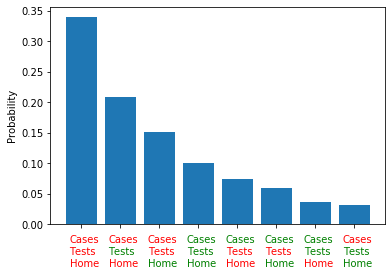

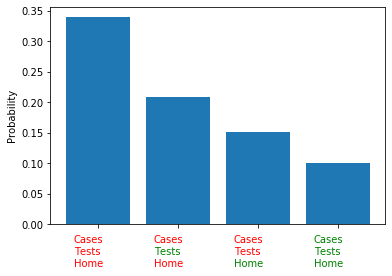

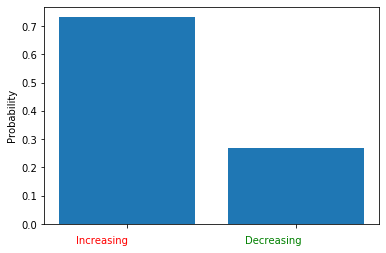

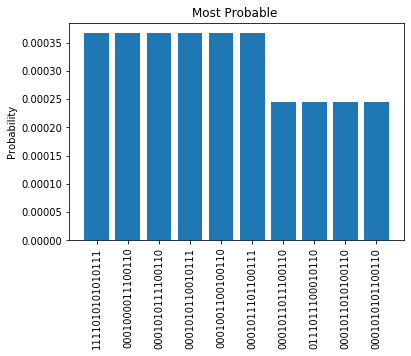

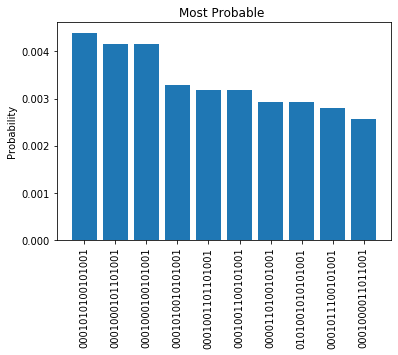

In [8]:
"""examples"""

var_labels = ['Cases', 'Tests', 'Home']

make_prob_hist(results, var_labels, top_n_probs='all')       
make_prob_hist(results, var_labels, top_n_probs=4)        
make_prob_hist(results_maxtomin, ['Increasing','Decreasing'], top_n_probs='all', whichvar=[0,2])  
make_prob_hist(topprobs_alabio_cases, varlabels, probdict = topprobs_alabio_cases)
make_prob_hist(topprobs_alabio_deaths, varlabels, probdict = topprobs_alabio_deaths)

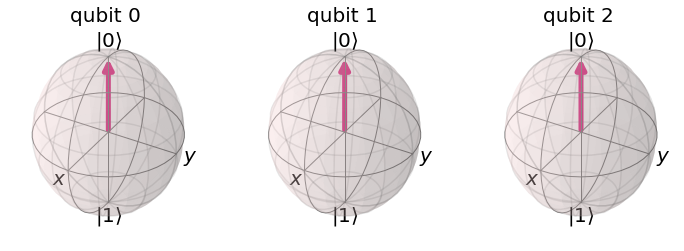

In [9]:
"""Lesser model before rotation - for presentation"""
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.id(0)

simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()

plot_bloch_multivector(statevector)


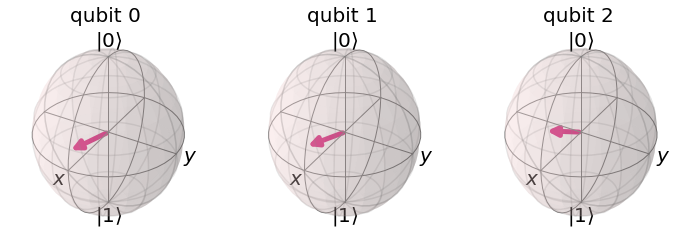

In [12]:
"""Lesser model after rotation - for presentation"""
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.ry(circ.angle_from_probability(.62,.38), 0)
qc.ry(circ.angle_from_probability(0.645,0.355), 1)
qc.ry(circ.angle_from_probability(0.73,0.27),2)

simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()

plot_bloch_multivector(statevector)